In [1]:
#importing the libraries
import math
import random 
import string 
import statistics
import time
import matplotlib.pyplot as plt

To start, we will writing some of the functions that will be helpful in the following tasks.

In [2]:
#this function creates an empty hash table of size N
def empty_hash_table(N):
    return [[] for n in range(N)]

#this function will be used to add random words 
#to the hash_table when I test different hash functions
def add_to_hash_table(hash_table, item, hash_function):
    #finding a location where the item will be inserted
    loc = hash_function(item, len(hash_table))
    #appending the item to the location
    hash_table[loc].append(item)
    return hash_table

def contains(hash_table, loc, i):
    count = 0
    for k in hash_table[loc]:
        if k[0] == i:
            count += 1
    if count > 0:
        return True
    else:
        return False

#this function is used to convert a string 
#into an integer given a certain value of d
#the reasons why i have it separately from the next function is because
#I need to use it separately as well
def string_convert(string, d):
    count = 0
    for i in range(len(string)):
        count += ord(string[i])*(d**(len(string)-1-i))
    return count

#this hash function takes an integer and returns a locaiton in a hash table
def hash1(integer, len_hash):
    return integer%len_hash

In the first version of the string matching algorithm we will have to pick some arbitary values: for instance d and q. In every case, d will be 7 and q will be the length of the hash table. Both options are prime numbers are seem to be plausible for a given scenario. Another point that is important to mention that I decided to not only store the substrings themselves but also the indices that correspond to the position ot those substrings in the input strings. This allowed me to keep track what what substrings are matched.

In [3]:
#this function creates a hash table that contains all substring with a length k 
def preprocessing(string, k, d):
    #here we merge all the words together in a lower case form
    string = string.lower().replace(' ', '')
    #creating a hash table - I chose the hash_table to be 
    #5 times bigger than the size of the has_table
    hash_table = empty_hash_table(5*(len(string)-k))
    #adding the first substring to the hashtable to be able to
    #start the rolling hashing
    hash_table[hash1(string_convert(string[0:k], d), 
                     len(hash_table))].append([string[0:k],0])
    for s in range(0, len(string)-k+1):
        #calculating the hashing value for the substring k + 1 letter
        h1 = (hash1(string_convert(string[s-1:s+k], d), len(hash_table))*d + 
              string_convert(string[s-1+k],d))%len(hash_table)
        #substracting the value of the first letter of the k+1 string 
        #this is basically the "rolling" part of the algorithm 
        #we add one letter and then subtract the first one at each iteration
        h2 = (h1 - string_convert(string[s-1],d)*
              ((d**(k+1))%len(hash_table)))%len(hash_table)
        #adding the substring to the hash table
        if contains(hash_table, h2, string[s:s+k]) == False:
            hash_table[h2].append([string[s:s+k], s])
        else:
            continue
    return hash_table

preprocessing("a great day!", 3, 4)
#i think it's not reaching the last substring

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [['agr', 0]],
 [['ay!', 7]],
 [],
 [],
 [['rea', 2], ['day', 6]],
 [],
 [],
 [],
 [['eat', 3]],
 [],
 [],
 [['atd', 4], ['tda', 5]],
 [],
 [],
 [],
 [],
 [],
 [],
 [['agr', 0], ['gre', 1]],
 [],
 [],
 []]

Further we can proceed to the final version of the function in which we use the preprocessing function. We will create a hash table that contains all substrings of x and then go through all substring of y and check if they are in the hash table to identify potential matches.

In [4]:
#the final substring matching function with the rolling hashing
#INPUT: two strings x and y, integer k which will define the length of the substring
#OUTPUT: indeces of the 
def rh_get_match(x, y, k):
    if x == '' or y == '':
        return ("One of the strings is empty, please use a non-empty input")
    else:
        #creating the hashtable with all substrings of x
        test_hash = preprocessing(x, k, 7)
        #creating empty lists for the positions of x and y matches
        y_matches = []
        x_matches = []
        #merging all the words together in a lower case form
        y = y.lower().replace(' ', '')
        x = x.lower().replace(' ', '')
        #going through all substrings of y
        for s in range(0, len(y)-k+1):
            h1 = (hash1(string_convert(y[s-1:s+k], 7), len(test_hash))*7 
                  + string_convert(y[s-1+k],7))%len(test_hash)
            h2 = (h1 - string_convert(y[s-1],7)*((7**(k+1))%len(test_hash)))%len(test_hash)
            #testing if the cell with the hash value of each substring is empty 
            if test_hash[h2] != []:
                #if not then we go through each value in that cell
                #to test if there is a match
                for i in test_hash[h2]:
                    #if yes tehn we print out the match and add indices to the lists x and y
                    #NOTE: we don't count the white spaces when counting the indices
                    if i[0] == y[s:s+k]:
                        #print("MATCH:", y[s:s+k], i[0])
                        y_matches.append(s)
                        x_matches.append(i[1])
    return x_matches, y_matches
                 
    
rh_get_match("Excuse me sir, but this chicken is mine", 
             "Hey boy, the let's go to kentucky fried chicken", 5)


([19, 20, 21], [32, 33, 34])

Our small test seems to give a correct result. We will analyze the results more extensively after introducing the second version of the algorithm.

For the second algorithm we need to pick a new hash function and given that we do not have to use rolling hashing, our choice becomes much more flexible. After a short research in Cormen et. al., I decided to analyze a hash that was suggested in class session 7.2, a function that uses a float multiplication method, a function that simply adds the integers representing unicode characters and a function what we used in the rolling hashing which adds the integers representing unicode characters but also raises them to the power of d which changes at each iteration. Ultimately what we are looking for is a hash function that does not cause too many collisions (meaning it uniformly distributes the keys) to avoid significant inflation of the running time. To test the hash functions, we will create 100,000 random words and put them in the hash tables using four different hash functions. Finally, we will measure the average number of collisions by counting how many items are in every non-empty bucket.

In [5]:
#here are four hash function that I will analyze for comparison
#some of them are obviously bad (hash3) but the other have potential to be good
#I researched some hashing techniques in Cormen et al. to test them here

#this hashing function goes through every character in a string
#finds the integer that corresponds to each letter
#adds it to the count and multiplies the count by 128
#it returns a location in a hash table which depends on its size
def hash2(string, len_hash):
    count = 0
    for chr in string:
        count = count * 128 + ord(chr)
    return count%len_hash

#here we simply add the integers that corresponds to each character
def hash3(string, len_hash):
    count = 0
    for chr in string:
        count += ord(chr)
    return count%len_hash

#this is the multiplication hashing technique in which we multiply the 
#count by a float between 0 and 1 an floor the product
def hash4(string, len_hash):
    c = 0.07
    count = 0
    for chr in string:
        count += ord(chr)
    return math.floor(len_hash*(count*(c%1)))%len_hash

#here we use a part of the rolling hasing function which adds the 
#integers that correspond to each number raised to a certain power 
#which depends on the position of the number in the string
def hash5(string, len_hash):
    count = string_convert(string, 7)
    return count%len_hash

In [6]:
#a function that outputs a random word of a given length
def randomword(length):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))

#creating a list of 100000 random words
words = []
for i in range(100000):
    words.append(randomword(10))

#creaing 4 empty hashtables    
hs1 = empty_hash_table(5000)
hs2 = empty_hash_table(5000)
hs3 = empty_hash_table(5000)
hs4 = empty_hash_table(5000)

#adding the words to every hash table using different hash functions
for i in words:
    add_to_hash_table(hs1, i, hash2)
    add_to_hash_table(hs2, i, hash3)
    add_to_hash_table(hs3, i, hash4)
    add_to_hash_table(hs4, i, hash5)
    
#to check how good the hash functions are we want to measure the # of collisions
#so we initiate the counts for the collisions 
count1 = count2 = count3 = count4 = 0
n1 = n2 = n3 = n4 = 0

#we update the counts to get the number of 
#non-empty buckets and number number of items in them
for i in hs1:
    if len(i) > 0:
        count1 += len(i)
        n1 += 1
for i in hs2:
    if len(i) > 0:
        count2 += len(i) 
        n2 += 1
for i in hs3:
    if len(i) > 0:
        count3 += len(i) 
        n3 += 1
for i in hs4:
    if len(i) > 0:
        count4 += len(i)
        n4 += 1
    
print('The average number of collisions with the first hash function is', count1/n1)
print('The average number of collisions with the second hash function is',count2/n2)
print('The average number of collisions with the third hash function is',count3/n3)
print('The average number of collisions with the fourth hash function is',count4/n4)

The average number of collisions with the first hash function is 20.0
The average number of collisions with the second hash function is 561.7977528089888
The average number of collisions with the third hash function is 1000.0
The average number of collisions with the fourth hash function is 20.0


As we can see, the hash functions that produce the smallest number of collisions are hash1 and hash4. For the next tasks we will proceed with hash4.

In [7]:
#here we create a hash table for the second approach
def preprocessing2(string, k):
    #here the everything is the same except we calculate the location 
    #in the hah table differently
    string = string.lower().replace(' ', '')
    hash_table = empty_hash_table(5*(len(string)-k))
    for s in range(len(string)-k+1):
        #we simply calculate it by using the hash function of our choice
        #however, we check if such letter isn't already in the hash_table
        #it is necessary for our plagiarism detection function 
        if contains(hash_table, hash4(string[s:s+k], len(hash_table)), string[s:s+k]) == False:
            hash_table[hash4(string[s:s+k], 
                             len(hash_table))].append([string[s:s+k], s])
        else: 
            continue
    return hash_table

preprocessing2("Today is a great day", 1)

[[['d', 2]],
 [],
 [],
 [['s', 6]],
 [],
 [['e', 10]],
 [],
 [],
 [],
 [['t', 0]],
 [],
 [],
 [],
 [],
 [],
 [['g', 8]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [['i', 5]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [['y', 4]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [['o', 1]],
 [],
 [['a', 3]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [['r', 9]],
 []]

In [8]:
def regular_get_match(x, y, k):
    #here the process is the same as in the previous get_match function
    if x == '' or y == '':
        return ("One of the strings is empty, please use a non-empty input")
    else:
        test_hash = preprocessing2(x, k)
        y_matches = []
        x_matches = []
        y = y.lower().replace(' ', '')
        x = x.lower().replace(' ', '')
        for s in range(len(y)-k+1):
            #the only difference is the hash function that we are using
            if test_hash[hash4(y[s:s+k], len(test_hash))] != []:
                for i in test_hash[hash4(y[s:s+k], len(test_hash))]:
                    if i[0] == y[s:s+k]:
                        #print("MATCH:", y[s:s+k], i[0])
                        y_matches.append(s)
                        x_matches.append(i[1])
    return x_matches,y_matches

regular_get_match("Excuse me sire, but this chicken is mine", 
                  "Hey boy, the let's go to kentucky fried chicken", 5)



([20, 21, 22], [32, 33, 34])

As we can see, the regular_get_match function produced the same result as the rolling hashing version of the algorithm.

How we can test both algorithms using three different test cases. In the first test case we will use two identical strings, in the second test case we will use two strings that don't have any characters in common and in the last test case one of the substrings will be empty.

In [9]:
a1 = 'It is our choices that show what we truly are, far more than our abilities'
print(len(a1.lower().replace(' ', '')))
b1 = 'Ooops, I did it again'
b2 = 'wPk zym'

c3 = ''

print(rh_get_match(a1, a1, 5))
print(regular_get_match(a1, a1, 5))
print("___________________________")
print(rh_get_match(b1, b2, 5))
print(regular_get_match(b1, b2, 5))
print("___________________________")
print(rh_get_match(a1, c3, 5))
print(regular_get_match(a1, c3, 5))


60
([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55])
([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55])
___________________________
([], [])
([], [])
___________________________
One of the strings is empty, please use a non-empty input

As expected, in the first case both algorithms return all of the indices (except for the last k ones). Further, as expected both algorithm return empty lists for the second case and an error for the last case. We can conclude that both algorithms work well.

Since these algortihms allow us to basically see how similar two text strings are, we can use them for plagiarism detection. A way to use the algorithms is calculating the number of matches and dividing it by the number of all potential substrings. This will give us a percentage of the identical substrings and therefore the level of similarity between two strings. In the next cell, I will provide two new strings to test the algorithm.

In [10]:
d1 = 'plagiarism is an act or instance of using or closely imitating the language and thoughts of another author without authorization'
d2 = 'plagiarism is an act of copying the ideas or words of another person without giving credit to that person'


In [11]:
#function that returns the percentage of the similarity of two texts
#INPUT: two texts, integer k that finds matching substrings of length k
def similarity_detection(text1, text2, k):
    #fidning the number of matching substrings in one of the lists that the 
    #get_match functions output and multiplying it by 2 because the number of matches 
    #is equal in both lists
    a = len(regular_get_match(text1, text2, k)[1])*2
    #counting the number of characters in each text
    b = len(text1.lower().replace(' ', ''))
    c = len(text2.lower().replace(' ', ''))
    #returning the similarity percentage which in which we divide the number of matches 
    #by the overall number of substrings in both texts
    return "The similarity level for strings is", a/(b+c-2*(k-1)) * 100
            
print(similarity_detection(d1, d2, 7))
print(similarity_detection(a1, a1, 3))
print(similarity_detection(b1, b2, 7))

('The similarity level for strings is', 18.478260869565215)
('The similarity level for strings is', 100.0)
('The similarity level for strings is', 0.0)


As we can see, the results look somewhat plausible. For two somewhat similar strings, the similarity percentage is 18.48%, and for two edge cases the similarities are 100% and 0% as expected. Further we can test whether the results are the same if we use the second algorithm.

In [12]:
def similarity_detection2(text1, text2, k):
    a = len(rh_get_match(text1, text2, k)[1])*2
    b = len(text1.lower().replace(' ', ''))
    c = len(text2.lower().replace(' ', ''))
    return "The similarity level is", a/(b+c-2*(k-1)) * 100
            
#checking if the results are the same with the second algorithm
print(similarity_detection2(d1, d2, 7))
print(similarity_detection2(a1, a1, 7))
print(similarity_detection2(b1, b2, 7))

('The similarity level is', 18.478260869565215)
('The similarity level is', 100.0)
('The similarity level is', 0.0)


As we can see, they are indeed the same.

The advantage of this algorithm is that it allows us to identify the identical substrings from two texts and by manipulating one line of the code we can make the code return all of the matches. One of the disadvantages of this algorithm is that if we pick a k that is too small, it will inflate the similarity percentage because the same word can consist of a couple of substrings. For instance if the word "amazing" is in both texts and the k is 4 then the common matches would be "amaz", "mazi", "azin" and "zing" which is 4 similarities instead of 1. A way to overcome this would be picking a k that is large enough to avoid that - 6 and higher (since the filler words that might repeat a lot usually consist of 3-4-5 letters). Further, we would have to identigy a threshold that will define whether one of the strings is plagiarized. This would depend on the particular field we are talking about - for instance if we compared two physics or math reports, the threshold would probably have to be higher because technical jargon might be repeated a lot (for instance I used the word "matrix" around 60 times in my CS111B final project), whereas for AH essays, the threshold would have to be lower.  

The problems that I see with this algorithm include:  
a) The function does not distinguish between what are the words in English and what are not the words, so many matches that it would return are nonsense words. A way to overcome that would be to have a hash table with all English words and just check every match - if it is in the dictionry, we can use it for calculating the similarities. Even taking that into account, the algorithm would make mistakes because some substring might indeed be words but in the actual text they just happened to be a part of a word (i.e., CATegory & advoCATions).  


**Time complexity of two versions of string matching algorithms**  
To identify the time complexities of both algorithms we can looks the the codes and identify important parts that would contribute to the asymptotic growth of the runtime. Let's call the length of the first stirng m and the length of the second string n. For the rh_get_match algorithm, the first part of the code is the preprocessing function. In the for loop that is a part of the preprocessing step, we are doing through m-k substrings. For each of the substrings we calculate a hash value and the run time of such process depends on the length of the substring. We do not really care about the growth of the runtime of the hashing function because k will always stay as a relatively small and the runtime of the algorithm will generally depend on the lengths of the strings. Further after the preprocessing step, we will iterate through n-k substrings of the second string. In that case also use the same hashing function. Another part of the algorithm that needs to be considered is the for loop in which we are going through all items in non-empty cells and the run time of that for loop would depend on the number of collisions in the cells of the hash table - given the tests that we performed, both hash functions that were used for the rh_get_match and regular_get_match algorithms were pretty efficient at resolving collisions, so we will not take into account the runtime growth from that part of the code. Finally, my prediction is that the overall time complexity would then be $O(m-k+(n-k))$ = $O(m+n-2*k))$. The same time complexity would apply to another algorithm which has the same structure, expect a different hash function used. Therefore, we would expect the runtime difference come entirely from the efficiency of the hash functions.  
Now we can create a function that will genereate strings with which we can analyze the asymptotic growth of the running time for both algorithms.

In [13]:
#a function that create one big string using as many words as we specify
def string_generator(n):
    words = []
    for i in range(0,n):
        words.append(randomword(10))
    words1 = [words[0]]
    for i in words:
        words1[0] = words1[0]+i
    return words1

In [21]:
#here we are creating two lists in which we will store the run times
t1_1 = []
t1_2 = []
#at each iteration we 
for i in range(1, 1000, 10):
    test1 = []
    test2 = []
    for k in range(10): 
        string1 = string_generator(i)
        a1 = time.time()
        regular_get_match(string1[0], string1[0], 2)
        b1 = time.time()
        test1.append(b1-a1)
        a2 = time.time()
        rh_get_match(string1[0], string1[0], 2)
        b2 = time.time()
        test2.append(b2-a2)
    t1_1.append(sum(test1)/len(test1))
    t1_2.append(sum(test2)/len(test2))

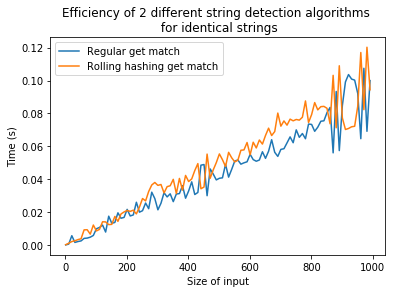

In [22]:
#here we are plotting the time it takes to find the matches
x = list(range(1, 1000, 10))

plt.plot(x,t1_1,label = "Regular get match")
plt.plot(x,t1_2,label = "Rolling hashing get match")

plt.title("Efficiency of 2 different string detection algorithms \n for identical strings")
plt.ylabel("Time (s)")
plt.xlabel("Size of input")
plt.legend(loc="upper left")
plt.show()

In [23]:
t2_1 = []
t2_2 = []

#here we also recor the run times but this time for two random strings
#we randomly create the first one and then shuffle it to make the second string
for i in range(1, 1000, 10):
    test1 = []
    test2 = []
    for k in range(10): 
        string1 = string_generator(i)
        l = list(string1[0])
        random.shuffle(l)
        string2 = ''.join(l)
    
        a1 = time.time()
        regular_get_match(string1[0], string2, 2)
        b1 = time.time()
        test1.append(b1-a1)
    
        a2 = time.time()
        rh_get_match(string1[0], string2, 2)
        b2 = time.time()
        test2.append(b2-a2)
    t2_1.append(sum(test1)/len(test1))
    t2_2.append(sum(test2)/len(test2))

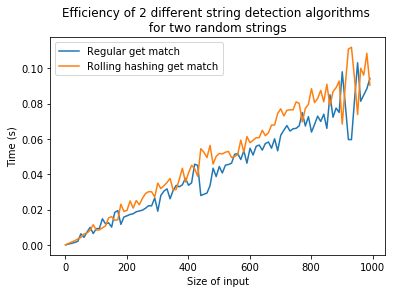

In [24]:
x = list(range(1, 1000, 10))

plt.plot(x,t2_1,label = "Regular get match")
plt.plot(x,t2_2,label = "Rolling hashing get match")

plt.title("Efficiency of 2 different string detection algorithms \n for two random strings ")
plt.ylabel("Time (s)")
plt.xlabel("Size of input")
plt.legend(loc="upper left")

As we can see, in both cases the regular get match function performs better which is quite unexpected given that in the instructions of the assignment it was mentioned that by not using the rolling hashing we are compromising the running time. The potential reasoning for such difference is the way we calculate the hash values in both cases - in case of the rolling hashing, there are more constants that are needed to calcualte the hashing value. Another observation is that in both cases, although slightly difference the growth is linear, so my estimation of the time complexity is plausible. 